In [2]:
import glob
import sys


import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

sys.path.append("..")
from src.process_data import *
from src.utils import * 

%load_ext autoreload
%autoreload 2

unable to import 'smart_open.gcs', disabling that module


In [3]:
raw_data_path = Path("..\\data\\raw\\")

In [4]:
# file_path = list(raw_data_path.glob("*.tsv"))[0]
# with open(file_path, encoding="utf-8") as f:
#     text, df = text_from_tsv(f)
#data = generate_token_sentiment_list(df)

data = load_data(raw_data_path)#, sample_size=50)

In [5]:
input_data = list(zip(*data))

In [6]:
X = input_data[0]
y_bin = input_data[1]

y_orig = input_data[2]

In [7]:
X = np.array(X)
y = np.vstack([y_bin, y_orig]).T

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    random_state=42)

In [9]:
X_train, X_test = n_gram(X_train, X_test)

In [10]:
X_tr_df = pd.DataFrame(X_train.todense(), dtype=int)
X_te_df = pd.DataFrame(X_test.todense(), dtype=int)

y_tr_df = pd.DataFrame(y_train[:, 0], dtype=int)
y_te_df = pd.DataFrame(y_test[:, 0], dtype=int)

In [11]:
# transform y to binary
y_tr_df[0] = y_tr_df[0].apply(to_binary) 
y_te_df[0] = y_te_df[0].apply(to_binary) 

print(y_tr_df.head())

X_tr_df['label'] = y_tr_df[0]
X_te_df['label'] = y_te_df[0]

tr_sh = X_tr_df.shape
te_sh = X_te_df.shape

   0
0  0
1  0
2  1
3  0
4  0


In [12]:
# convert to libfmm format
feature_index_dict = convert_and_save_df(X_tr_df, 
                        [], 
                        list(range(tr_sh[1] - 1)), 
                        "fm/train_n_gram", 
                        feature_index_dict=None)

convert_and_save_df(X_te_df, 
                        [], 
                        list(range(te_sh[1] - 1)), 
                        "fm/test_n_gram", 
                        feature_index_dict=feature_index_dict)

{0: {0: 1, 1: 15641, 6: 22507, 2: 25000, 3: 34696, 4: 64},
 1: {0: 2, 1: 28776},
 2: {0: 3, 1: 19805, 2: 31719},
 3: {0: 4, 1: 30901},
 4: {0: 5, 1: 30605, 3: 35911},
 5: {0: 6, 1: 34200, 2: 39521},
 6: {0: 7, 1: 30902},
 7: {0: 8, 1: 26960, 2: 856},
 8: {0: 9, 1: 25961},
 9: {0: 10, 1: 20104},
 10: {0: 11, 1: 36408},
 11: {0: 12, 1: 33450},
 12: {0: 13, 1: 26726},
 13: {0: 14, 1: 36388},
 14: {0: 15, 1: 17530, 5: 35912},
 15: {0: 16, 1: 24191},
 16: {0: 17, 1: 18816},
 17: {0: 18, 1: 30260},
 18: {0: 19, 1: 37464},
 19: {0: 20, 1: 16085, 2: 20837, 3: 27954},
 20: {0: 21, 1: 24216},
 21: {0: 22, 1: 29257},
 22: {0: 23, 1: 23637},
 23: {0: 24, 1: 17531},
 24: {0: 25, 1: 31479},
 25: {0: 26, 1: 40285},
 26: {0: 27, 2: 33536, 1: 39561},
 27: {0: 28, 1: 15672},
 28: {0: 29, 2: 36530},
 29: {0: 30, 1: 30322},
 30: {0: 31, 1: 26156},
 31: {0: 32, 1: 20838, 2: 23796},
 32: {0: 33, 1: 29893, 2: 38559},
 33: {0: 34, 1: 18817},
 34: {0: 35, 1: 31627},
 35: {0: 36, 1: 17467, 2: 30966},
 36: {0: 3

In [ ]:
import xlearn as xl
param = {
    "task": "binary",
    "lr": 0.3,
    "lambda": 0.00002,
    "metric": "auc",
    "k": 4
}
cur_train = "fm/train_n_gram"
cur_test = "fm/test_n_gram"

fm_model = xl.create_ffm() # Use field-aware factorization machine
fm_model.setTrain(cur_train)  # Training data
fm_model.setValidate(cur_train)  # Validation data

# Start to train
# The trained model will be stored in model.out
fm_model.fit(param, "fm/model.out")

# Prediction task
fm_model.setTest(cur_test)  # Test data
fm_model.setSigmoid()  # Convert output to 0-1

# Start to predict
# The output result will be stored in output.txt
fm_model.predict("fm/model.out", "fm/output.txt")

In [20]:
from sklearn.metrics import roc_curve
def results_evaluation(df, output_file_path, threshold=0.5):
        output_file = pd.read_csv(output_file_path, names=['label'])

        y_test = df['label']
        y_pred = output_file['label']
        
        y_pred_binarized = [1 if x > threshold else 0 for x in y_pred]
        #print(y_pred)
        print("\nAUC: {}".format(roc_auc_score(y_test, y_pred)))
        print("AUC binarized: {}".format(roc_auc_score(y_test, y_pred_binarized)))
        print("Precision: {}".format(precision_score(y_test, y_pred_binarized)))
        print("Recall: {}".format(recall_score(y_test, y_pred_binarized)))
        
        return roc_curve(y_test, y_pred)

In [44]:
fpr, tpr, _= results_evaluation(X_te_df, "fm/output.txt", threshold=0.1771)


AUC: 0.6670458662415768
AUC binarized: 0.6175434147284014
Precision: 0.41277641277641275
Recall: 0.450402144772118


In [39]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


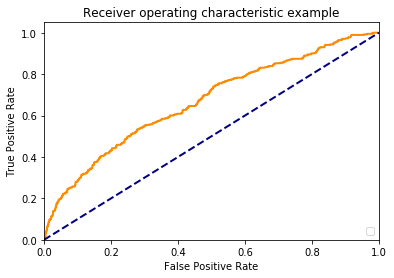

In [53]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)#, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def convert_and_save_df(df, numerical_fields, categorical_fields, filename, feature_index_dict=None):

    all_fields = numerical_fields + categorical_fields
    field_type = dict((f, "num" if f in numerical_fields else "cat") for f in all_fields)
    if not feature_index_dict:
        feature_index_dict = {}

    global_feature_ind = len(numerical_fields)

    with open(filename, "w") as text_file:

        for row in zip(*(df[f] for f in ["label"] + all_fields)):
            datastring = str(int(row[0]))

            
            for field_index, field in enumerate(all_fields):

                # encode field index
                datastring += f" {field_index}:"

                # current field value
                field_value = row[field_index + 1]

               
                if field_type[field] == "num":
                    datastring += f"{field_index}:{field_value}"

                else:
                    if field not in feature_index_dict:
                        feature_index_dict[field] = {}

                    if field_value not in feature_index_dict[field]:
                        #print("adding new features")
                        global_feature_ind += 1
                        feature_index_dict[field][field_value] = global_feature_ind

                    feature_index = feature_index_dict[field][field_value]
                    datastring += f"{feature_index}:1"

            datastring += "\n"
            text_file.write(datastring)

    return feature_index_dict